# Import Librariies

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import Xception
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from PIL import Image


import os
import random


import warnings
warnings.filterwarnings("ignore")

2025-07-09 19:35:34.680606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752089734.870802      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752089734.928228      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Get Data

In [2]:
image_folder_path = '/kaggle/input/Teeth_Dataset'
train_path = '/kaggle/input/Teeth_Dataset/Training'
test_path = '/kaggle/input/Teeth_Dataset/Testing'
validation_path = '/kaggle/input/Teeth_Dataset/Validation'

In [3]:
folders = list(os.listdir(image_folder_path))
print(folders)

['Validation', 'Training', 'Testing']


In [4]:
train_data = tf.keras.utils.image_dataset_from_directory(train_path)
test_data = tf.keras.utils.image_dataset_from_directory(test_path)
validation_data = tf.keras.utils.image_dataset_from_directory(validation_path)

Found 3087 files belonging to 7 classes.


I0000 00:00:1752089749.897747      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


In [5]:
diseases = list(os.listdir(os.path.join(image_folder_path,'Testing')))
print(diseases)

['OC', 'CaS', 'OT', 'CoS', 'Gum', 'MC', 'OLP']


# Prepare Data

In [6]:
def plot_1_per_disease_in_folder(folder):
    fig, axes = plt.subplots(1, len(diseases), figsize=(10, 10))

    for ax, disease in zip(axes, diseases):
        diseases_dir = os.path.join(image_folder_path, folder, disease)
        valid_extensions = ('.jpeg', '.jpg', '.bmp', '.png')
        diseases_images = list(filter(lambda x: x.endswith(valid_extensions), os.listdir(diseases_dir)))

        if diseases_images:
            img_path = os.path.join(diseases_dir, random.choice(diseases_images))
            image = plt.imread(img_path)
            ax.imshow(image)
            ax.set_title(disease)
            ax.axis('off')
        else:
            ax.set_title(f'No images for {illness}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()
    


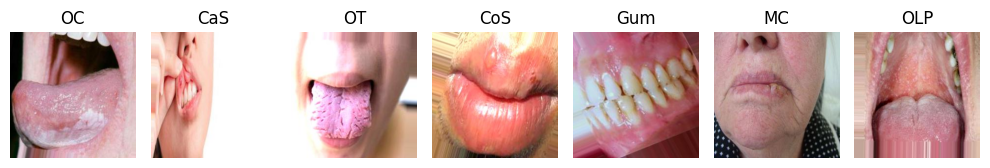

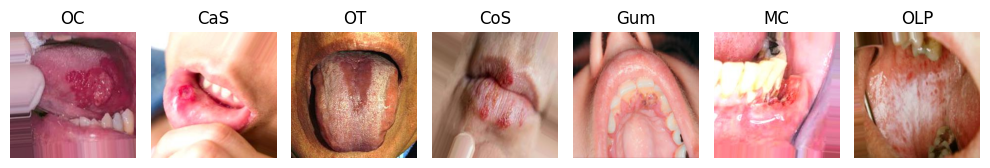

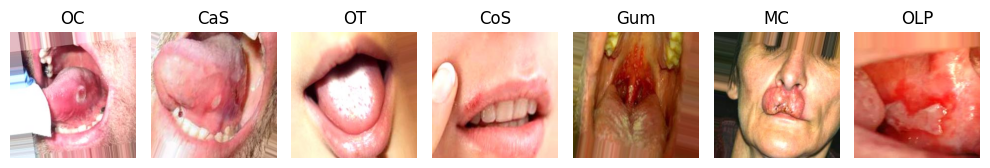

In [7]:

plot_1_per_disease_in_folder(folders[0] )

plot_1_per_disease_in_folder(folders[1] )

plot_1_per_disease_in_folder(folders[2] )


In [ ]:

def load_train_data_and_preprocess_it(train_data, target_size, batch_size):
    train_gen = ImageDataGenerator(
        rescale =  1/255.0,
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest',
    )

    train = train_gen.flow_from_directory(
        train_data,
        target_size = target_size,
        batch_size = batch_size,
        class_mode = 'categorical'
    )

    return train

def load_validation_data_and_preprocess_it(validation_data, target_size, batch_size):
    validation_gen = ImageDataGenerator(
        rescale =  1/255.0,
    )

    validation = validation_gen.flow_from_directory(
        validation_data,
        target_size = target_size,
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = False
    )

    return validation


In [9]:
train = load_train_data_and_preprocess_it(
                train_path,
                target_size=(150, 150),
                batch_size=32
                )

validation = load_validation_data_and_preprocess_it(
                validation_path,
                target_size=(150, 150),
                batch_size=32
                )

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [10]:
imgs, labels = next(train)
print(imgs.shape)
print(labels.shape)

(32, 150, 150, 3)
(32, 7)


In [11]:
print(train.class_indices)
print(validation.class_indices)

{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}
{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}


In [ ]:
bad_images = []

base_path = '/kaggle/input/teethdataset/Teeth_Dataset/Training'

for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.lower().endswith(('jpg', 'jpeg', 'png')):
            try:
                img = Image.open(os.path.join(root, file))
                img.verify()  # Will raise an exception if the image is corrupted
            except:
                bad_images.append(os.path.join(root, file))

print("Bad images:", bad_images)


Bad images: []


# Modeling Xception

## Feature Extraction

In [13]:

input_shape = (150, 150, 3)

base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(7, activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [41]:
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 74, 74,    │        864 │ input_layer_3[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 74, 74,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 74, 74,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 72, 72,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 72, 72,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 72, 72,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 72, 72,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 72, 72,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 72, 72,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 72, 72,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 72, 72,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 36, 36,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 36, 36,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 36, 36,    │        512 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_36 (Add)        │ (None, 36, 36,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 36, 36,    │          0 │ add_36[0][0]    

 Total params: 47,079,983 (179.60 MB)

 Trainable params: 26,218,503 (100.02 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [42]:
plot_model(
    model,
    to_file='Xception_Feature_Extraction.png',    
    show_shapes=True,    
    show_layer_names=True
)

In [43]:
history = model.fit(
    train,
    epochs=40,
    validation_data=validation,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 37s 291ms/step - accuracy: 0.3706 - loss: 2.2258 - val_accuracy: 0.6381 - val_loss: 1.0192 - learning_rate: 1.0000e-04
Epoch 2/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 217ms/step - accuracy: 0.5628 - loss: 1.1863 - val_accuracy: 0.6741 - val_loss: 0.9038 - learning_rate: 1.0000e-04
Epoch 3/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - accuracy: 0.6112 - loss: 1.0639 - val_accuracy: 0.7091 - val_loss: 0.8052 - learning_rate: 1.0000e-04
Epoch 4/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 213ms/step - accuracy: 0.6455 - loss: 0.9493 - val_accuracy: 0.7588 - val_loss: 0.6977 - learning_rate: 1.0000e-04
Epoch 5/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - accuracy: 0.6570 - loss: 0.9146 - val_accuracy: 0.7811 - val_loss: 0.6302 - learning_rate: 1.0000e-04
Epoch 6/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - accuracy: 0.6973 - loss: 0.8226 - val_accuracy: 0.7967 - val_loss: 0.5940 - learning_rate: 1.0000e-04
Epoch 7/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 212ms/step - acc

<Axes: >

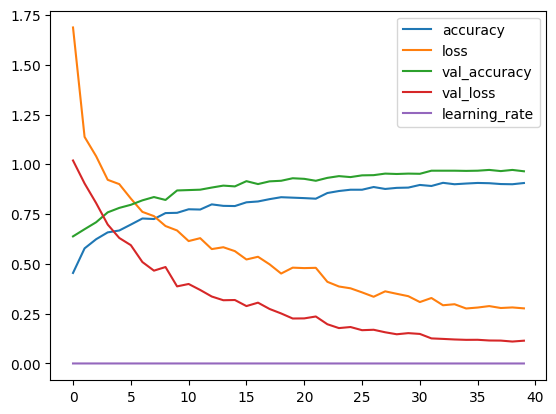

In [44]:
model_history = history.history
loss_acc_df = pd.DataFrame(model_history)
loss_acc_df.plot()

In [14]:
acc = model_history['accuracy']
val_acc = model_history['val_accuracy']
loss = model_history['loss']
val_loss = model_history['val_loss']

epochs = model.history.epoch

def plot_acc(acc, val_acc, epochs):
  plt.plot(epochs, acc, label='Training Accuracy')
  plt.plot(epochs, val_acc, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc=0)
  plt.show()


def plot_loss(loss, val_loss, epochs):
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc=0)
  plt.show()


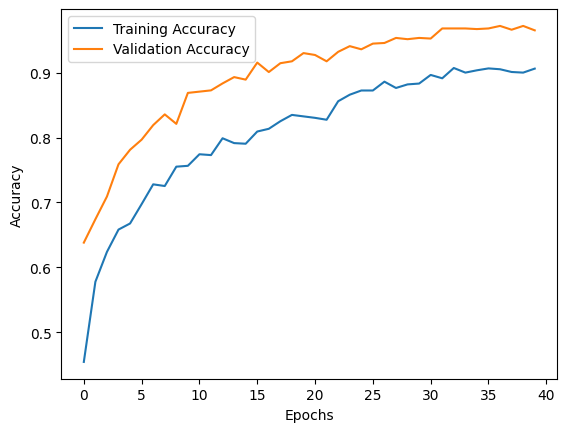

In [46]:
plot_acc(acc, val_acc, epochs)

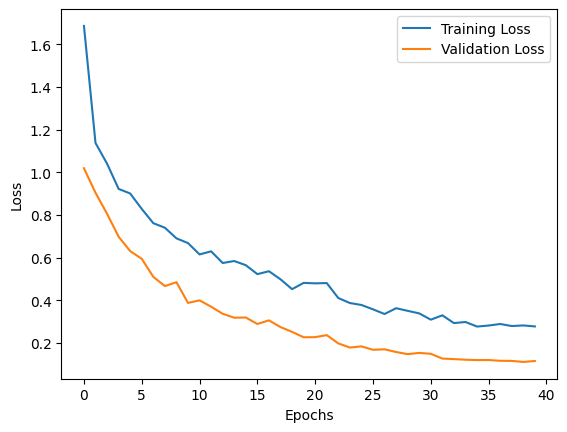

In [47]:
plot_loss(loss, val_loss, epochs)

In [15]:
test = load_validation_data_and_preprocess_it(
                test_path,
                target_size=(150, 150),
                batch_size=32
        )

Found 1028 images belonging to 7 classes.


In [49]:
test_loss, test_accuracy = model.evaluate(test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9774 - loss: 0.0874


In [50]:
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 0.12270534783601761
Test Accuracy: 0.9591439962387085


In [51]:
predictions = model.predict(test)


y_pred = np.argmax(predictions, axis=1)
y_true = test.classes


class_labels = list(test.class_indices.keys())


report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step
              precision    recall  f1-score   support

         CaS       0.94      0.99      0.97       160
         CoS       0.99      0.99      0.99       149
         Gum       0.97      0.97      0.97       120
          MC       0.94      0.95      0.95       180
          OC       0.89      0.93      0.91       108
         OLP       0.98      0.91      0.95       180
          OT       0.98      0.98      0.98       131

    accuracy                           0.96      1028
   macro avg       0.96      0.96      0.96      1028
weighted avg       0.96      0.96      0.96      1028



<Figure size 800x600 with 0 Axes>

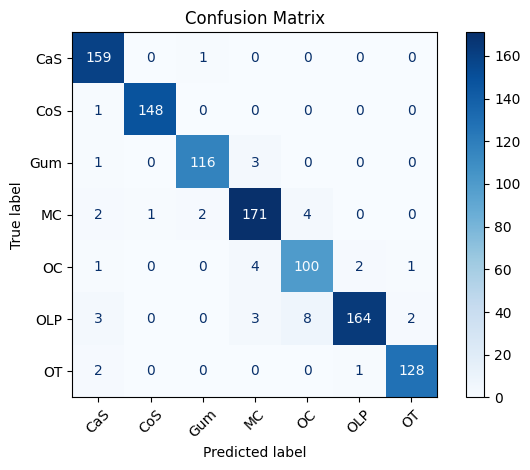

In [52]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

In [53]:
model.save('Xception_Feature_Extraction.keras')

## Fine-Tuning

In [16]:
input_shape = (150, 150, 3)

base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = True

# Add custom layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(7, activation='softmax')(x)

# Create final model
fine_tuned_model = Model(inputs=base_model.input, outputs=output_layer)



In [17]:
print(len(base_model.layers))


132


In [18]:
for layer in base_model.layers[:100]:
    layer.trainable = False

In [19]:
# Compile the model
fine_tuned_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
) # It's commot to use a smaller learning rate for 'ConvNet' weights that are being fine-tuned


# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

In [20]:
fine_tuned_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 74, 74,    │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 74, 74,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 74, 74,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 72, 72,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 72, 72,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 72, 72,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 72, 72,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 72, 72,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 72, 72,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 72, 72,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 72, 72,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 36, 36,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 36, 36,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 36, 36,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 36, 36,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 36, 36,    │          0 │ add_12[0][0]    

 Total params: 47,079,983 (179.60 MB)

 Trainable params: 35,696,847 (136.17 MB)

 Non-trainable params: 11,383,136 (43.42 MB)

In [59]:
plot_model(
    fine_tuned_model,
    to_file='Xception_fine_tuned.png',    
    show_shapes=True,    
    show_layer_names=True
)

In [21]:
fine_tuned_history = fine_tuned_model.fit(
    train,
    epochs=50,
    validation_data=validation,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


I0000 00:00:1752089871.374589     112 service.cc:148] XLA service 0x7cd4b8002bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752089871.375452     112 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752089872.904259     112 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1752089876.505925     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752089876.691851     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752089877.293610     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752089877.4942

 2/97 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.1719 - loss: 2.0037  

I0000 00:00:1752089882.487065     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


92/97 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step - accuracy: 0.2259 - loss: 1.9178

E0000 00:00:1752089918.447686     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752089918.632731     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752089919.083903     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752089919.282939     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752089919.692174     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

97/97 ━━━━━━━━━━━━━━━━━━━━ 81s 581ms/step - accuracy: 0.2299 - loss: 1.9111 - val_accuracy: 0.5068 - val_loss: 1.3336 - learning_rate: 1.0000e-05
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 233ms/step - accuracy: 0.4569 - loss: 1.5492 - val_accuracy: 0.6411 - val_loss: 1.0552 - learning_rate: 1.0000e-05
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 233ms/step - accuracy: 0.5576 - loss: 1.2731 - val_accuracy: 0.6848 - val_loss: 0.9137 - learning_rate: 1.0000e-05
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 241ms/step - accuracy: 0.6296 - loss: 1.0625 - val_accuracy: 0.7412 - val_loss: 0.7473 - learning_rate: 1.0000e-05
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 235ms/step - accuracy: 0.6597 - loss: 0.9632 - val_accuracy: 0.8016 - val_loss: 0.6287 - learning_rate: 1.0000e-05
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 238ms/step - accuracy: 0.7005 - loss: 0.8419 - val_accuracy: 0.8356 - val_loss: 0.5662 - learning_rate: 1.0000e-05
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.73

<Axes: >

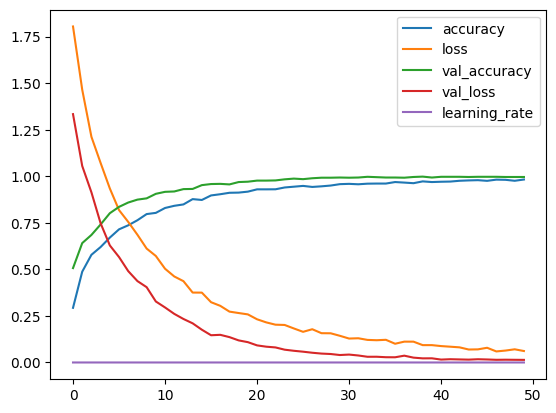

In [22]:
fine_tuned_model_history = fine_tuned_history.history
fine_tuned_loss_acc_df = pd.DataFrame(fine_tuned_model_history)
fine_tuned_loss_acc_df.plot()

In [23]:
fine_tuned_acc = fine_tuned_model_history['accuracy']
fine_tuned_val_acc = fine_tuned_model_history['val_accuracy']
fine_tuned_loss = fine_tuned_model_history['loss']
fine_tuned_val_loss = fine_tuned_model_history['val_loss']

fine_tuned_epochs = fine_tuned_model.history.epoch

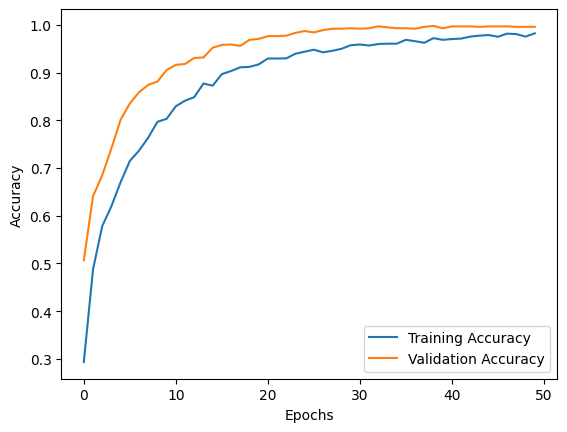

In [24]:
plot_acc(fine_tuned_acc, fine_tuned_val_acc, fine_tuned_epochs)

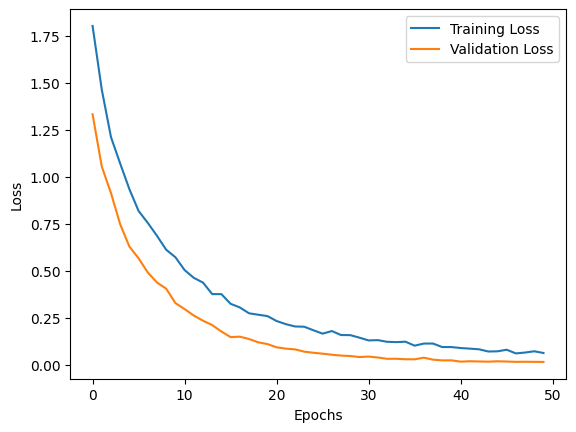

In [25]:
plot_loss(fine_tuned_loss, fine_tuned_val_loss, fine_tuned_epochs)

In [26]:
fine_tuned_test_loss, fine_tuned_test_accuracy = fine_tuned_model.evaluate(test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - accuracy: 0.9958 - loss: 0.0136


In [27]:
print(f"Test Loss: {fine_tuned_test_loss}")
print(f"Test Accuracy: {fine_tuned_test_accuracy}")

Test Loss: 0.02678658813238144
Test Accuracy: 0.994163453578949


In [28]:
fine_tuned_predictions = fine_tuned_model.predict(test)


fine_tuned_y_pred = np.argmax(fine_tuned_predictions, axis=1)
fine_tuned_y_true = test.classes


class_labels = list(test.class_indices.keys())


fine_tuned_report = classification_report(fine_tuned_y_true, fine_tuned_y_pred, target_names=class_labels, digits=4)
print(fine_tuned_report)

33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step
              precision    recall  f1-score   support

         CaS     1.0000    0.9938    0.9969       160
         CoS     1.0000    1.0000    1.0000       149
         Gum     0.9836    1.0000    0.9917       120
          MC     0.9889    0.9889    0.9889       180
          OC     0.9907    0.9907    0.9907       108
         OLP     1.0000    0.9889    0.9944       180
          OT     0.9924    1.0000    0.9962       131

    accuracy                         0.9942      1028
   macro avg     0.9937    0.9946    0.9941      1028
weighted avg     0.9942    0.9942    0.9942      1028



<Figure size 800x600 with 0 Axes>

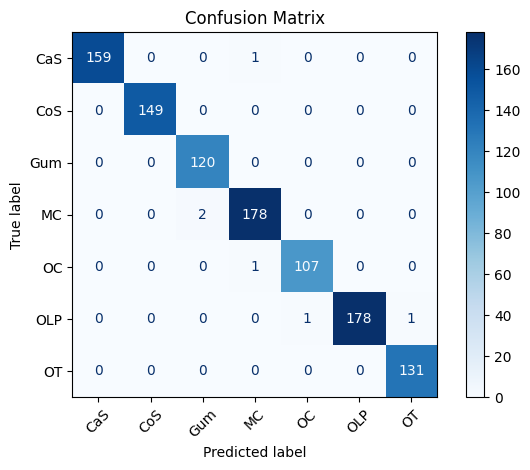

In [29]:
fine_tuned_cm = confusion_matrix(fine_tuned_y_true, fine_tuned_y_pred)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=fine_tuned_cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

In [30]:
fine_tuned_model.save('Xception_fine_tuned.keras')

# The Best Model is `Xception_fine_tuned` With 'F1_score = 99.42%'

## Save Details About The Best Model

In [74]:
#Save the training history
with open('Xception_finetuned_History.pkl', 'wb') as f:
    pickle.dump(fine_tuned_history.history, f)